In [13]:
import os
from os import path
from functools import reduce
import re
import pandas as pd
from rouge import Rouge
import nltk
import numpy as np
import random
import sys
import tqdm
import matplotlib.pyplot as plt
from collections import Counter
from nltk.translate.bleu_score import corpus_bleu
from nltk.tokenize import wordpunct_tokenize

In [20]:
def calc_metrics(refs, hyps, data, metric="all"):
    metrics = dict()
    metrics["count"] = len(hyps)
    metrics["text_example"] = data[-1]
    metrics["ref_example"] = refs[-1]
    metrics["hyp_example"] = hyps[-1]
    many_refs = [[r] if r is not list else r for r in refs]
    if metric in ("bleu", "all"):
        metrics["bleu"] = corpus_bleu(many_refs, hyps)
    if metric in ("rouge", "all"):
        rouge = Rouge()
        scores = rouge.get_scores(hyps, refs, avg=True)
        metrics.update(scores)
    return metrics


def print_metrics(refs, hyps, data, metric="all"):
    metrics = calc_metrics(refs, hyps, data, metric)

    print("-------------METRICS-------------")
    print("Count:\t", metrics["count"])
    print("Text:\t", metrics["text_example"])
    print("Ref:\t", metrics["ref_example"])
    print("Hyp:\t", metrics["hyp_example"])

    if "bleu" in metrics:
        print("BLEU:     \t{:3.1f}".format(metrics["bleu"] * 100.0))
    if "rouge-1" in metrics:
        print("ROUGE-1-F:\t{:3.1f}".format(metrics["rouge-1"]['f'] * 100.0))
        print("ROUGE-2-F:\t{:3.1f}".format(metrics["rouge-2"]['f'] * 100.0))
        print("ROUGE-L-F:\t{:3.1f}".format(metrics["rouge-l"]['f'] * 100.0))
        print('ROUGE-mean\t{:3.1f}'.format((metrics["rouge-1"]['f'] + \
                                            metrics["rouge-2"]['f'] + \
                                            metrics["rouge-l"]['f']) * 100.0 / 3))


In [21]:
def n_grams(tokens, n):
    l = len(tokens)
    return [tuple(tokens[i:i + n]) for i in range(l) if i + n < l]

def has_repeat(elements):
    d = set(elements)
    return len(d) < len(elements)

def cal_self_repeat(summary):
    ngram_repeats = {2: 0, 4: 0, 8: 0}
    sents = summary.split('<q>')
    for n in ngram_repeats.keys():
        # Respect sentence boundary
        grams = reduce(lambda x, y: x + y, [n_grams(sent.split(), n) for sent in sents], [])
        ngram_repeats[n] += has_repeat(grams)
    return ngram_repeats

def cal_novel(summary, gold, source, summary_ngram_novel, gold_ngram_novel):
    summary = summary.replace('<q>',' ')
    summary = re.sub(r' +', ' ', summary).strip()
    gold = gold.replace('<q>',' ')
    gold = re.sub(r' +', ' ', gold).strip()
    source = source.replace(' ##','')
    source = source.replace('[CLS]',' ').replace('[SEP]',' ').replace('[PAD]',' ')
    source = re.sub(r' +', ' ', source).strip()


    for n in summary_ngram_novel.keys():
        summary_grams = set(n_grams(summary.split(), n))
        gold_grams = set(n_grams(gold.split(), n))
        source_grams = set(n_grams(source.split(), n))
        joint = summary_grams.intersection(source_grams)
        novel = summary_grams - joint
        summary_ngram_novel[n][0] += 1.0*len(novel)
        summary_ngram_novel[n][1] += len(summary_grams)
        summary_ngram_novel[n][2] += 1.0 * len(novel) / (len(summary.split()) + 1e-6)
        joint = gold_grams.intersection(source_grams)
        novel = gold_grams - joint
        gold_ngram_novel[n][0] += 1.0*len(novel)
        gold_ngram_novel[n][1] += len(gold_grams)
        gold_ngram_novel[n][2] += 1.0 * len(novel) / (len(gold.split()) + 1e-6)


def cal_repeat(cand, gold, data):
    lines = zip(cand, gold, data)

    summary_ngram_novel = {1: [0, 0, 0], 2: [0, 0, 0], 3: [0,0,0]}
    gold_ngram_novel = {1: [0, 0, 0], 2: [0, 0, 0], 3: [0,0,0]}

    for c,g,s in lines:
        # self_repeats = cal_self_repeat(c)
        cal_novel(c, g, s,summary_ngram_novel, gold_ngram_novel)
    print(summary_ngram_novel)
    print(gold_ngram_novel)
    print('-'*80)
    for n in summary_ngram_novel.keys():
        summary_ngram_novel[n] = summary_ngram_novel[n][0]/summary_ngram_novel[n][1]
        gold_ngram_novel[n] = gold_ngram_novel[n][0]/gold_ngram_novel[n][1]
    print(summary_ngram_novel)
    print(gold_ngram_novel)
    return summary_ngram_novel, gold_ngram_novel

### mBART on RIA

In [49]:
with open('results/ria_mbart.candidate', 'r') as f:
    ria_cand_mbart = f.readlines()

ria_cand_mbart = [' '.join(wordpunct_tokenize(el.strip())) 
                  for el in ria_cand_mbart]


with open('results/ria_mbart.gold', 'r') as f:
    ria_gold_mbart = f.readlines()

ria_gold_mbart = [' '.join(wordpunct_tokenize(el.strip())) for el in ria_gold_mbart]

with open('results/ria_mbart.raw_src', 'r') as f:
    ria_text_mbart = f.readlines()
    
ria_text_mbart = [' '.join(wordpunct_tokenize(el.strip())) for el in ria_text_mbart]

In [50]:
empty_prediction_cnt = 0

for i in range(len(ria_cand_mbart)):
    if ria_cand_mbart[i] == '':
        ria_cand_mbart[i] = '-'
        empty_prediction_cnt += 1
        
print('Empty predictions number =', empty_prediction_cnt)

Empty predictions number = 3


In [51]:
print_metrics(ria_gold_mbart, ria_cand_mbart, ria_text_mbart)

-------------METRICS-------------
Count:	 49940
Text:	 ( агентство риа новости не несет ответственности за информацию , опубликованную российскими газетами ). коммерсант www . kommersant . ru — с банки на банк — из административного запаса эльвира набиуллина уходит на пост председателя цб — вчера президент россии владимир путин в ново - огарево заявил , что предложит госдуме утвердить на пост главы центробанка своего помощника эльвиру набиуллину . — михаила гуцериева вывели на " красную поляну " — предпринимателю может достаться пакет братьев билаловых — семья билаловых , раскритикованная в феврале владимиром путиным за срыв сроков строительства трамплинов в сочи к олимпиаде , может выйти из этого проекта . ее долю , оцениваемую в $ 395 млн , в компании " красная поляна " может приобрести совладелец " русснефти " михаил гуцериев . его появление в проекте можно объяснить не только политической волей , но и хорошими отношениями семьи гуцериевых с другим акционером " красной поляны " — сб

### mBART on Lenta

In [55]:
with open('results/lenta_mbart.candidate', 'r') as f:
    lenta_cand_mbart = f.readlines()

lenta_cand_mbart = [' '.join(wordpunct_tokenize(el.strip())) for el in lenta_cand_mbart]


with open('results/lenta_mbart.gold', 'r') as f:
    lenta_gold_mbart = f.readlines()

lenta_gold_mbart = [' '.join(wordpunct_tokenize(el.strip())) for el in lenta_gold_mbart]

with open('results/lenta_mbart.raw_src', 'r') as f:
    lenta_data_mbart = f.readlines()
    
lenta_data_mbart = [' '.join(wordpunct_tokenize(el.strip())) for el in lenta_data_mbart]

In [56]:
empty_prediction_cnt = 0

for i in range(len(lenta_cand_mbart)):
    if lenta_cand_mbart[i] == '':
        lenta_cand_mbart[i] = '-'
        empty_prediction_cnt += 1
        
print('Empty predictions number =', empty_prediction_cnt)

Empty predictions number = 611


In [57]:
print_metrics(lenta_gold_mbart, lenta_cand_mbart, lenta_data_mbart)

-------------METRICS-------------
Count:	 75925
Text:	 одинсотрудник абхазской таможни сегодня утром убит , трое - ранены врезультате обстрела из засады в населенном пункте тагилони вгальском района абхазии в зоне безопасности , контролируемоймиротворческими силами снг . об этом сегодня сообщиликорреспонденту итар - тасс в службе безопасности гальского района . по словам начальника службы безопасности алексея аршбы , взасаду попал таможенный патруль ( инцидент произошелприблизительно в 5 километрах от грузино - абхазской границы ). правоохранительные органы района этот инцидент расценивают какдиверсионный акт , совершенный грузинской диверсионной группой . к этому часу трое раненых на вертолете доставлены в сухуми , им сделаны операции . по словам главврача больницы , состояниеодного из раненых тяжелое . жизнь двух других - вне опасности . в самом конце августа мандат российских миротворцев в абхазии был продлен на несколько месяцев . это решение принято грузией , считающей абхазию сво

### BertSumAbs RIA

In [58]:
ITERATION = '40000'

In [60]:
with open('results/ria_40k.' + ITERATION + '.gold', 'r') as f:
    ria_gold = f.readlines()
    
ria_gold = [el.strip().lower() for el in ria_gold]
ria_gold = [' '.join(wordpunct_tokenize(el.strip())) for el in ria_gold]


with open('results/ria_40k.' + ITERATION + '.candidate', 'r') as f:
    ria_cand = f.readlines()

ria_cand = [el.strip().lower() for el in ria_cand]
ria_cand = [' '.join(wordpunct_tokenize(el.strip())) for el in ria_cand]


ria_data = pd.read_csv('results/ria_40k.' + ITERATION + '.raw_src', sep='\n', names=['text'])
ria_data = [el.replace(' ##', '').replace('[CLS]', '').replace('[SEP]', '') for el in ria_data.text.values]
ria_data = [' '.join(wordpunct_tokenize(el.strip())) for el in ria_data]


assert(len(ria_data) == len(ria_gold) and len(ria_gold) == len(ria_cand))

In [61]:
print_metrics(ria_gold, ria_cand, ria_data)

-------------METRICS-------------
Count:	 49253
Text:	 москва , 13 окт - риа новости . очередной день отборочных матчей чемпионата европы по футболу 2012 года запомнился , кроме победы сборной россии в скопье над македонцами ( 1 : 0 ) , нулевой ничьей англичан с черногорцами в лондоне , сложной победой действующих чемпионов европы и мира испанцев в шотландии , а также отмена матча в генуе , где выяснить отношения итальянцам и сербам помешали фанатские выходки . группа с матч сборных италии и сербии не был сыгран из - за беспорядков , устроенных болельщиками команды гостей . они еще перед началом встречи жгли файеры , бросали предметы на поле и в сторону поклонников " скуадры адзурры " . в результате футболистам , выйдя на газон , пришлось вернуться в раздевалки , пока стюарды пытались успокоить разгоряченных фанов . однако организаторам так и не удалось усмирить пылких сербов , и шотландский судья крэйг александер томпсон принял решение об отмене матча . сербские сми связывают агрессив

### BertSumAbs Lenta

In [69]:
with open('results/lenta_40k.' + ITERATION + '.gold', 'r') as f:
    lenta_gold = f.readlines()
    
lenta_gold = [el.strip().lower() for el in lenta_gold]
lenta_gold = [' '.join(wordpunct_tokenize(el.strip())) for el in lenta_gold]


with open('results/lenta_40k.' + ITERATION + '.candidate', 'r') as f:
    lenta_cand = f.readlines()

lenta_cand = [el.strip().lower() for el in lenta_cand]
lenta_cand = [' '.join(wordpunct_tokenize(el.strip())) for el in lenta_cand]


lenta_data = pd.read_csv('results/lenta_40k.' + ITERATION + '.raw_src', sep='\n', names=['text'])
lenta_data = [el.replace(' ##', '').replace('[CLS]', '').replace('[SEP]', '') for el in lenta_data.text.values]
lenta_data = [' '.join(wordpunct_tokenize(el.strip())[:200]) for el in lenta_data]

assert(len(lenta_data) == len(lenta_gold) and len(lenta_gold) == len(lenta_cand))

In [70]:
print_metrics(lenta_gold, lenta_cand, lenta_data)

-------------METRICS-------------
Count:	 75971
Text:	 сегодня в окленде ( новая зеландия ) , в рамках саммита по экономическому сотрудничеству в азиатско - тихоокеанском регионе ( apec ) прошла встреча министра иностранных дел россии игоря иванова с государственным секретарем сша мадлен олбрайт . в ходе встречи рассматривался широкий круг проблем двусторонних российско - американских отношений и международной обстановки . на совместной пресс - конференции олбрайт и иванова , отвечая на вопрос о недавнем скандале с отмыванием " русских денег " в американских банках , олбрайт заявила : " я не думаю , что это отразится на российско - американских отношениях " . она подчеркнула , что именно иванов предложил послать в сша представителей российских спецслужб , чтобы помочь разобраться в этой истории . в свою очередь российский министр подчеркнул , что даже если " отмытые " деньги действительно принадлежат российским криминальным структурам , то банки , в которых эти деньги оказались - амери

### Novel n-gram proportion

In [67]:
ria_cand_nov_m, ria_gold_nov_m = cal_repeat(ria_cand_mbart, ria_gold_mbart, ria_text_mbart)

lenta_cand_nov_m, lenta_gold_nov_m = cal_repeat(lenta_cand_mbart, lenta_gold_mbart, lenta_data_mbart)

ria_cand_nov, ria_gold_nov = cal_repeat(ria_cand, ria_gold, ria_data)

lenta_cand_nov, lenta_gold_nov = cal_repeat(lenta_cand, lenta_gold, lenta_data)

{1: [26637.0, 423602, 2789.6856964539024], 2: [108666.0, 390194, 11096.330566741713], 3: [150702.0, 340593, 15122.009788959123]}
{1: [121525.0, 425236, 12540.635899537567], 2: [251637.0, 392074, 25235.844913661593], 3: [274650.0, 342708, 27079.855296541285]}
--------------------------------------------------------------------------------
{1: 0.06288213936666966, 2: 0.2784922371948313, 3: 0.44246945768116197}
{1: 0.2857824831387747, 2: 0.6418099644454873, 3: 0.801411113834518}
{1: [40606.0, 607509, 4367.235662047725], 2: [151917.0, 550490, 16161.068448506763], 3: [203925.0, 476112, 21343.561012406153]}
{1: [203253.0, 537525, 24534.347847496636], 2: [338372.0, 474667, 39812.24478637052], 3: [340471.0, 399767, 39028.94238011857]}
--------------------------------------------------------------------------------
{1: 0.06684016203875169, 2: 0.2759668658831223, 3: 0.42831308599657225}
{1: 0.37812752895214174, 2: 0.7128618589453237, 3: 0.8516735998719254}
{1: [74673.0, 414377, 7760.626083975833

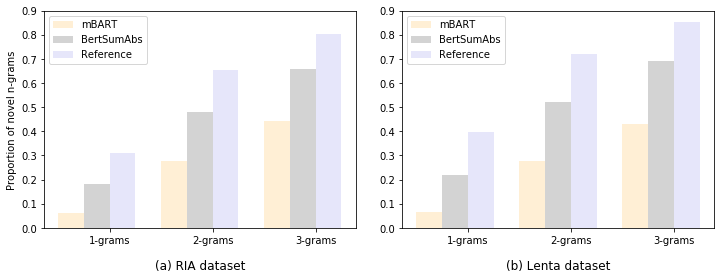

In [68]:
fig, ax = plt.subplots(1,2)
fig.set_figheight(4)
fig.set_figwidth(12)
fig.subplots_adjust(wspace=0.15)



ind = np.arange(3)    # the x locations for the groups
width = 0.25         # the width of the bars

p0 = ax[0].bar(ind - width, ria_cand_nov_m.values(), width, color='papayawhip')
p1 = ax[0].bar(ind, ria_cand_nov.values(), width, color='lightgray')
p2 = ax[0].bar(ind + width, ria_gold_nov.values(), width, color='lavender')


ax[0].set_xticks(ind + width / 2)
ax[0].set_xticklabels(('1-grams', '2-grams', '3-grams', '4-grams'))
ax[0].yaxis.set_ticks(np.arange(0, 1, 0.1))

    
ax[0].set_ylabel('Proportion of novel n-grams')
ax[0].legend((p0[0], p1[0], p2[0]), ('mBART', 'BertSumAbs', 'Reference'))
ax[0].set_title('(a) RIA dataset', y=-0.22)


###########################################################################################

p3 = ax[1].bar(ind - width, lenta_cand_nov_m.values(), width, color='papayawhip')
p4 = ax[1].bar(ind, lenta_cand_nov.values(), width, color='lightgray')
p5 = ax[1].bar(ind + width, lenta_gold_nov.values(), width, color='lavender')

ax[1].set_xticks(ind + width / 2)
ax[1].set_xticklabels(('1-grams', '2-grams', '3-grams', '4-grams'))
ax[1].yaxis.set_ticks(np.arange(0, 1, 0.1))

    
ax[1].legend((p3[0], p4[0], p5[0]), ('mBART', 'BertSumAbs', 'Reference'))
ax[1].set_title('(b) Lenta dataset', y=-0.22)


plt.draw()
fig.savefig('novel_ngrams.eps', bbox_inches='tight', format='eps')

### First Sentence Baseline

In [22]:
lenta_fs_cand = []
for el in lenta_data:
    try:
        lenta_fs_cand.append(el.split('.')[0].strip())
    except Exception:
        lenta_fs_cand.append(el)
    if not lenta_fs_cand[-1]:
        lenta_fs_cand[-1] = el

In [23]:
print_metrics(lenta_gold, lenta_fs_cand, lenta_data)

-------------METRICS-------------
Count:	 75971
Text:	 сегодня в окленде ( новая зеландия ) , в рамках саммита по экономическому сотрудничеству в азиатско - тихоокеанском регионе ( apec ) прошла встреча министра иностранных дел россии игоря иванова с государственным секретарем сша мадлен олбрайт . в ходе встречи рассматривался широкий круг проблем двусторонних российско - американских отношений и международной обстановки . на совместной пресс - конференции олбрайт и иванова , отвечая на вопрос о недавнем скандале с отмыванием " русских денег " в американских банках , олбрайт заявила : " я не думаю , что это отразится на российско - американских отношениях " . она подчеркнула , что именно иванов предложил послать в сша представителей российских спецслужб , чтобы помочь разобраться в этой истории . в свою очередь российский министр подчеркнул , что даже если " отмытые " деньги действительно принадлежат российским криминальным структурам , то банки , в которых эти деньги оказались - амери

In [24]:
ria_fs_cand = []
for el in ria_data:
    try:
        ria_fs_cand.append(el.split('.')[1].strip())
    except Exception:
        ria_fs_cand.append(el)
    if not ria_fs_cand[-1]:
        ria_fs_cand[-1] = el

In [25]:
print_metrics(ria_gold, ria_fs_cand, ria_data)

-------------METRICS-------------
Count:	 49253
Text:	 москва , 13 окт - риа новости . очередной день отборочных матчей чемпионата европы по футболу 2012 года запомнился , кроме победы сборной россии в скопье над македонцами ( 1 : 0 ) , нулевой ничьей англичан с черногорцами в лондоне , сложной победой действующих чемпионов европы и мира испанцев в шотландии , а также отмена матча в генуе , где выяснить отношения итальянцам и сербам помешали фанатские выходки . группа с матч сборных италии и сербии не был сыгран из - за беспорядков , устроенных болельщиками команды гостей . они еще перед началом встречи жгли файеры , бросали предметы на поле и в сторону поклонников " скуадры адзурры " . в результате футболистам , выйдя на газон , пришлось вернуться в раздевалки , пока стюарды пытались успокоить разгоряченных фанов . однако организаторам так и не удалось усмирить пылких сербов , и шотландский судья крэйг александер томпсон принял решение об отмене матча . сербские сми связывают агрессив

#### Rouge

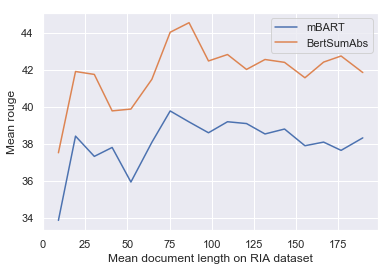

In [147]:
plt.plot((mean_len + mean_len_m) / 2, mean_r_m, label='mBART')
plt.plot((mean_len + mean_len_m) / 2, mean_r, label='BertSumAbs')
plt.xlabel('Mean document length on RIA dataset')
plt.legend()
plt.ylabel('Mean rouge');
plt.savefig('mean_rouge.eps', bbox_inches='tight', format='eps')

#### BLEU

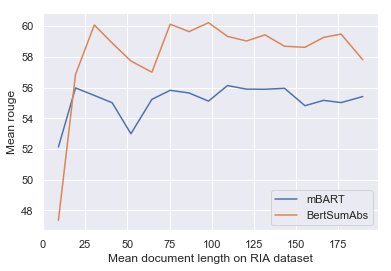

In [148]:
plt.plot((mean_len + mean_len_m) / 2, mean_b_m, label='mBART')
plt.plot((mean_len + mean_len_m) / 2, mean_b, label='BertSumAbs')
plt.xlabel('Mean document length on RIA dataset')
plt.legend()
plt.ylabel('Mean rouge');
plt.savefig('mean_bleu.eps', bbox_inches='tight', format='eps')

### LOGS

In [46]:
with open('logs/abs_bert_ria') as f:
    data = f.readlines()

In [47]:
train_scores = []
val_scores = []

prev_train = None
for j, el in enumerate(data):
    if 'INFO] Step ' in el:
        assert not prev_train
        
        step_start = el.find('INFO] Step ') + 11
        step_end = el.find('/200000; acc:')
        step_num = int(el[step_start:step_end])
        
        acc_start = el.find('/200000; acc:  ') + 15
        acc_end = el.find('; ppl:')
        acc = float(el[acc_start:acc_end])
        
        xent_start = el.find('; xent: ') + 8
        xent_end = el.find('; lr: 0.00')
        xent = float(el[xent_start:xent_end])
        
        train_scores.append((step_num, acc, xent))
        prev_train = True
        
    if  ' INFO] Validation accuracy: ' in el and prev_train is True:
        acc = float(el[el.find('accuracy: ') + 10:-2])
        xent =  float(data[j+1][data[j+1].find(' xent:') + 6:-2])
        val_scores.append((acc, xent))
        
        prev_train = False
        

In [48]:
steps = [el[0] for el in train_scores]

In [49]:
train_scores = train_scores[:steps.index(5200)] + train_scores[steps.index(6800) + 1:]
val_scores = val_scores[:steps.index(5200)] + val_scores[steps.index(6800) + 1:]
steps = steps[:steps.index(5200)] + steps[steps.index(6800) + 1:]

In [50]:
import seaborn as sns
sns.set()

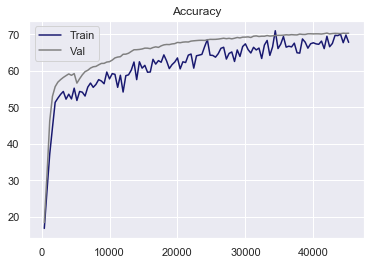

In [23]:
plt.plot(steps, np.array([el[1] for el in train_scores]), label='Train', color='midnightblue')
plt.plot(steps, np.array([el[0] for el in val_scores]), label='Val', color='grey')
plt.title('Accuracy')
plt.legend()
plt.show()

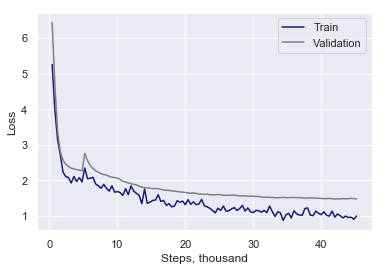

In [58]:
plt.plot(np.array(steps) / 1000, np.array([el[2] for el in train_scores]), label='Train', color='midnightblue')
plt.plot(np.array(steps) / 1000, np.array([el[1] for el in val_scores]), label='Validation', color='grey')
plt.xlabel('Steps, thousand')
plt.ylabel('Loss')
plt.legend()
plt.draw()
plt.savefig('train.eps', bbox_inches='tight', format='eps')